# Task 4: Loan Approval Prediction

## Objective

Build a classification model to predict whether a loan application will be approved. This project focuses on handling imbalanced data, missing values, and categorical feature encoding while comparing multiple classification algorithms.

**Key Requirements:**
1. Load and explore the Loan-Approval-Prediction dataset
2. Handle missing values appropriately
3. Encode categorical features
4. Address class imbalance using SMOTE
5. Train Logistic Regression and Decision Tree models
6. Evaluate using precision, recall, and F1-score
7. Compare model performance

**Tools and Libraries:**
- Python
- pandas, NumPy
- Scikit-learn
- Imbalanced-learn (SMOTE)
- Matplotlib, Seaborn

## 1. Import Libraries and Load Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    precision_score, recall_score, f1_score, confusion_matrix,
    classification_report, accuracy_score, roc_auc_score, roc_curve
)
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print('All libraries imported successfully!')

All libraries imported successfully!


In [17]:
# Load the loan approval dataset
df = pd.read_csv('/Users/emmanuel.siyanbola/Downloads/Machine Learning Track/loan_approval_dataset.csv')

print('Loan Approval Dataset Loaded')
print(f'Shape: {df.shape}')
print(f'\nFirst few rows:')
print(df.head())
print(f'\nColumn names:')
print(df.columns.tolist())

Loan Approval Dataset Loaded
Shape: (4269, 13)

First few rows:
   loan_id   no_of_dependents      education  self_employed   income_annum  \
0        1                  2       Graduate             No        9600000   
1        2                  0   Not Graduate            Yes        4100000   
2        3                  3       Graduate             No        9100000   
3        4                  3       Graduate             No        8200000   
4        5                  5   Not Graduate            Yes        9800000   

    loan_amount   loan_term   cibil_score   residential_assets_value  \
0      29900000          12           778                    2400000   
1      12200000           8           417                    2700000   
2      29700000          20           506                    7100000   
3      30700000           8           467                   18200000   
4      24200000          20           382                   12400000   

    commercial_assets_value   luxu

## 2. Explore the Dataset

In [18]:
# Clean column names (remove leading spaces)
df.columns = df.columns.str.strip()

print('Dataset Information:')
print(df.info())
print(f'\nDataset Shape: {df.shape}')
print(f'\nStatistical Summary:')
print(df.describe())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   loan_id                   4269 non-null   int64 
 1   no_of_dependents          4269 non-null   int64 
 2   education                 4269 non-null   object
 3   self_employed             4269 non-null   object
 4   income_annum              4269 non-null   int64 
 5   loan_amount               4269 non-null   int64 
 6   loan_term                 4269 non-null   int64 
 7   cibil_score               4269 non-null   int64 
 8   residential_assets_value  4269 non-null   int64 
 9   commercial_assets_value   4269 non-null   int64 
 10  luxury_assets_value       4269 non-null   int64 
 11  bank_asset_value          4269 non-null   int64 
 12  loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB
None

Dat

In [19]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

print('Missing Values:')
print('='*50)
for col in df.columns:
    if missing_values[col] > 0:
        print(f'{col}: {missing_values[col]} ({missing_percentage[col]:.2f}%)')

print(f'Total missing values: {missing_values.sum()}')

Missing Values:
Total missing values: 0


Target Variable Distribution:
loan_status
Approved    2656
Rejected    1613
Name: count, dtype: int64


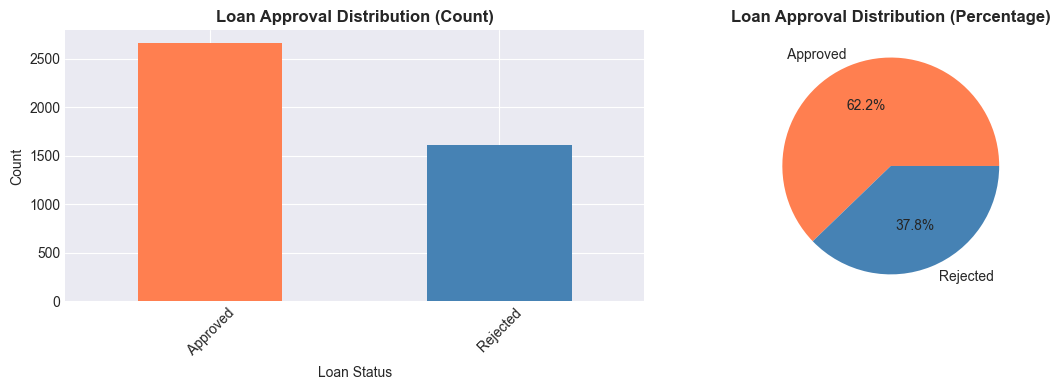

 Approved: 2656 (62.22%)
 Rejected: 1613 (37.78%)


In [25]:
# Target variable distribution
print('Target Variable Distribution:')
print('='*50)
loan_status = df['loan_status'].value_counts()
print(loan_status)

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

loan_status.plot(kind='bar', ax=axes[0], color=['coral', 'steelblue'])
axes[0].set_title('Loan Approval Distribution (Count)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Loan Status')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

loan_status.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=['coral', 'steelblue'])
axes[1].set_title('Loan Approval Distribution (Percentage)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

for status, count in loan_status.items():
    print(f'{status}: {count} ({(count/len(df))*100:.2f}%)')

## 3. Handle Missing Values

In [21]:
# Create a copy for preprocessing
df_processed = df.copy()

print('Handling Missing Values:')
print('='*50)

# For numerical columns: use median
numerical_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
if 'loan_id' in numerical_cols:
    numerical_cols.remove('loan_id')  # Remove ID column

for col in numerical_cols:
    if df_processed[col].isnull().sum() > 0:
        median_val = df_processed[col].median()
        df_processed[col].fillna(median_val, inplace=True)
        print(f'{col}: Filled with median = {median_val:.2f}')

# For categorical columns: use mode
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
if 'loan_status' in categorical_cols:
    categorical_cols.remove('loan_status')  # Remove target variable

for col in categorical_cols:
    if df_processed[col].isnull().sum() > 0:
        mode_val = df_processed[col].mode()[0]
        df_processed[col].fillna(mode_val, inplace=True)
        print(f'{col}: Filled with mode = {mode_val}')

print('\nMissing values after handling:')
print(f'Total missing values: {df_processed.isnull().sum().sum()}')

Handling Missing Values:

Missing values after handling:
Total missing values: 0


## 4. Encode Categorical Features

In [22]:
print('Encoding Categorical Features:')
print('='*50)

# Drop loan_id as it's not useful for prediction
df_processed = df_processed.drop('loan_id', axis=1)

# Identify categorical columns (excluding target)
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
if 'loan_status' in categorical_cols:
    categorical_cols.remove('loan_status')

# Use LabelEncoder for each categorical column
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    label_encoders[col] = le
    print(f'{col}: Encoded')

# Encode target variable (loan_status)
le_target = LabelEncoder()
df_processed['loan_status'] = le_target.fit_transform(df_processed['loan_status'])
print(f'loan_status: Encoded (Rejected=0, Approved=1)')

print('\nDataset after encoding:')
print(df_processed.head())
print(f'\nAll columns are now numerical. Shape: {df_processed.shape}')

Encoding Categorical Features:
education: Encoded
self_employed: Encoded
loan_status: Encoded (Rejected=0, Approved=1)

Dataset after encoding:
   no_of_dependents  education  self_employed  income_annum  loan_amount  \
0                 2          0              0       9600000     29900000   
1                 0          1              1       4100000     12200000   
2                 3          0              0       9100000     29700000   
3                 3          0              0       8200000     30700000   
4                 5          1              1       9800000     24200000   

   loan_term  cibil_score  residential_assets_value  commercial_assets_value  \
0         12          778                   2400000                 17600000   
1          8          417                   2700000                  2200000   
2         20          506                   7100000                  4500000   
3          8          467                  18200000                  3300000   

## 5. Split Data into Training and Testing Sets

In [23]:
# Separate features and target
X = df_processed.drop('loan_status', axis=1)
y = df_processed['loan_status']

print('Data Splitting:')
print('='*50)
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f'\nTraining set: {X_train.shape}')
print(f'Testing set: {X_test.shape}')
print(f'\nTraining set class distribution:')
print(f'Rejected (0): {(y_train==0).sum()}')
print(f'Approved (1): {(y_train==1).sum()}')
print(f'\nTesting set class distribution:')
print(f'Rejected (0): {(y_test==0).sum()}')
print(f'Approved (1): {(y_test==1).sum()}')

Data Splitting:
Features shape: (4269, 11)
Target shape: (4269,)

Training set: (3415, 11)
Testing set: (854, 11)

Training set class distribution:
Rejected (0): 2125
Approved (1): 1290

Testing set class distribution:
Rejected (0): 531
Approved (1): 323


## 6. Address Class Imbalance with SMOTE

Addressing Class Imbalance with SMOTE:
Before SMOTE:
Rejected (0): 2125
Approved (1): 1290

After SMOTE:
Rejected (0): 2125
Approved (1): 2125

New training set shape: (4250, 11)


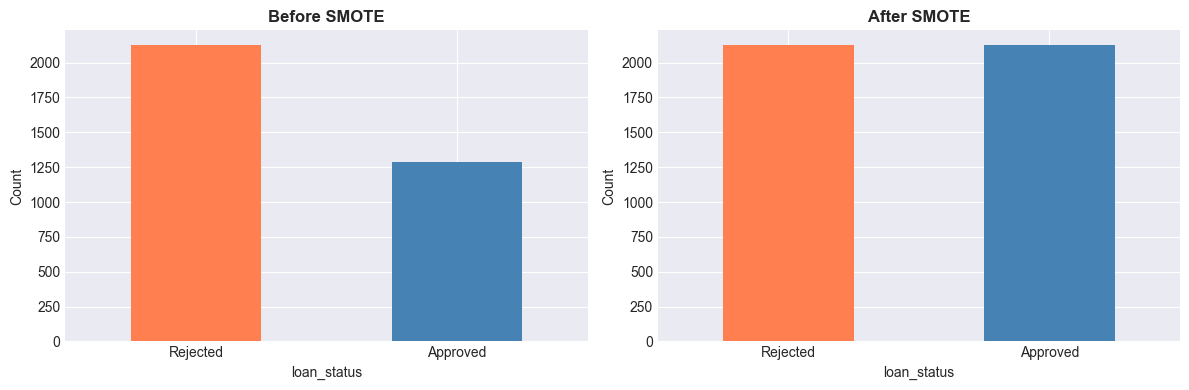

In [24]:
# Apply SMOTE to training data only
print('Addressing Class Imbalance with SMOTE:')
print('='*50)
print('Before SMOTE:')
print(f'Rejected (0): {(y_train==0).sum()}')
print(f'Approved (1): {(y_train==1).sum()}')

smote = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print('\nAfter SMOTE:')
print(f'Rejected (0): {(y_train_smote==0).sum()}')
print(f'Approved (1): {(y_train_smote==1).sum()}')
print(f'\nNew training set shape: {X_train_smote.shape}')

# Visualize class distribution before and after SMOTE
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

before_smote = pd.Series(y_train).value_counts().sort_index()
after_smote = pd.Series(y_train_smote).value_counts().sort_index()

before_smote.plot(kind='bar', ax=axes[0], color=['coral', 'steelblue'])
axes[0].set_title('Before SMOTE', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Rejected', 'Approved'], rotation=0)

after_smote.plot(kind='bar', ax=axes[1], color=['coral', 'steelblue'])
axes[1].set_title('After SMOTE', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['Rejected', 'Approved'], rotation=0)

plt.tight_layout()
plt.show()

## 7. Train Logistic Regression Model

In [26]:
# Scale features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

print('Training Logistic Regression Model:')
print('='*50)

# Train Logistic Regression
lr_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
lr_model.fit(X_train_scaled, y_train_smote)

# Make predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_lr_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print('Logistic Regression model trained successfully!')
print(f'\nModel coefficients (top 5 features):')  
feature_importance_lr = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_[0]
}).sort_values('Coefficient', ascending=False)
print(feature_importance_lr.head())

Training Logistic Regression Model:
Logistic Regression model trained successfully!

Model coefficients (top 5 features):
                    Feature  Coefficient
3              income_annum     1.656039
5                 loan_term     0.834033
7  residential_assets_value    -0.000076
0          no_of_dependents    -0.055250
8   commercial_assets_value    -0.111222


## 8. Train Decision Tree Model

In [27]:
print('Training Decision Tree Model:')
print('='*50)

# Train Decision Tree
dt_model = DecisionTreeClassifier(max_depth=10, random_state=RANDOM_STATE)
dt_model.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred_dt = dt_model.predict(X_test)
y_pred_dt_proba = dt_model.predict_proba(X_test)[:, 1]

print('Decision Tree model trained successfully!')
print(f'\nFeature importance (top 5 features):')
feature_importance_dt = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)
print(feature_importance_dt.head())

Training Decision Tree Model:
Decision Tree model trained successfully!

Feature importance (top 5 features):
               Feature  Importance
6          cibil_score    0.862162
5            loan_term    0.057964
4          loan_amount    0.031539
3         income_annum    0.019631
9  luxury_assets_value    0.007055


## 9. Evaluate Model Performance

In [28]:
# Calculate performance metrics for Logistic Regression
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)
lr_auc = roc_auc_score(y_test, y_pred_lr_proba)

print('Logistic Regression Performance:')
print('='*50)
print(f'Accuracy:  {lr_accuracy:.4f}')
print(f'Precision: {lr_precision:.4f}')
print(f'Recall:    {lr_recall:.4f}')
print(f'F1-Score:  {lr_f1:.4f}')
print(f'ROC-AUC:   {lr_auc:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred_lr, target_names=['Not Approved', 'Approved']))

Logistic Regression Performance:
Accuracy:  0.9286
Precision: 0.9068
Recall:    0.9040
F1-Score:  0.9054
ROC-AUC:   0.9735

Classification Report:
              precision    recall  f1-score   support

Not Approved       0.94      0.94      0.94       531
    Approved       0.91      0.90      0.91       323

    accuracy                           0.93       854
   macro avg       0.92      0.92      0.92       854
weighted avg       0.93      0.93      0.93       854



In [29]:
# Calculate performance metrics for Decision Tree
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_precision = precision_score(y_test, y_pred_dt)
dt_recall = recall_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt)
dt_auc = roc_auc_score(y_test, y_pred_dt_proba)

print('Decision Tree Performance:')
print('='*50)
print(f'Accuracy:  {dt_accuracy:.4f}')
print(f'Precision: {dt_precision:.4f}')
print(f'Recall:    {dt_recall:.4f}')
print(f'F1-Score:  {dt_f1:.4f}')
print(f'ROC-AUC:   {dt_auc:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred_dt, target_names=['Not Approved', 'Approved']))

Decision Tree Performance:
Accuracy:  0.9789
Precision: 0.9692
Recall:    0.9752
F1-Score:  0.9722
ROC-AUC:   0.9884

Classification Report:
              precision    recall  f1-score   support

Not Approved       0.98      0.98      0.98       531
    Approved       0.97      0.98      0.97       323

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



## 10. Confusion Matrices

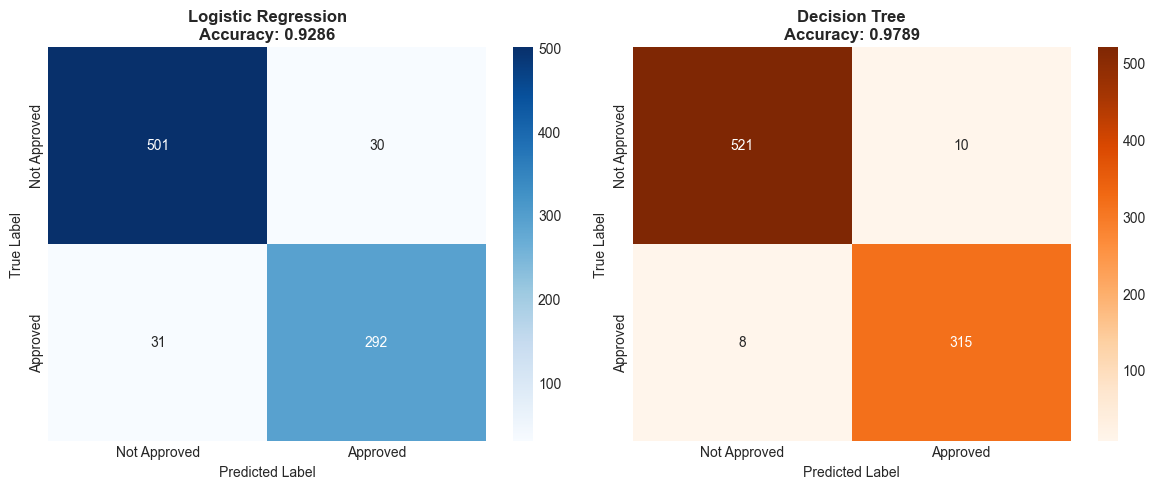

In [30]:
# Generate confusion matrices
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_dt = confusion_matrix(y_test, y_pred_dt)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Logistic Regression
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Not Approved', 'Approved'],
            yticklabels=['Not Approved', 'Approved'])
axes[0].set_title(f'Logistic Regression\nAccuracy: {lr_accuracy:.4f}', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Decision Tree
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=['Not Approved', 'Approved'],
            yticklabels=['Not Approved', 'Approved'])
axes[1].set_title(f'Decision Tree\nAccuracy: {dt_accuracy:.4f}', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

## 11. Compare Models

In [31]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree'],
    'Accuracy': [lr_accuracy, dt_accuracy],
    'Precision': [lr_precision, dt_precision],
    'Recall': [lr_recall, dt_recall],
    'F1-Score': [lr_f1, dt_f1],
    'ROC-AUC': [lr_auc, dt_auc]
})

print('Model Comparison:')
print('='*80)
print(comparison_df.to_string(index=False))

# Identify best model
best_f1_idx = comparison_df['F1-Score'].idxmax()
best_model_name = comparison_df.loc[best_f1_idx, 'Model']
best_f1 = comparison_df.loc[best_f1_idx, 'F1-Score']

print(f'\nBest Model (by F1-Score): {best_model_name} with F1-Score of {best_f1:.4f}')

Model Comparison:
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.928571   0.906832 0.904025  0.905426 0.973512
      Decision Tree  0.978923   0.969231 0.975232  0.972222 0.988412

Best Model (by F1-Score): Decision Tree with F1-Score of 0.9722


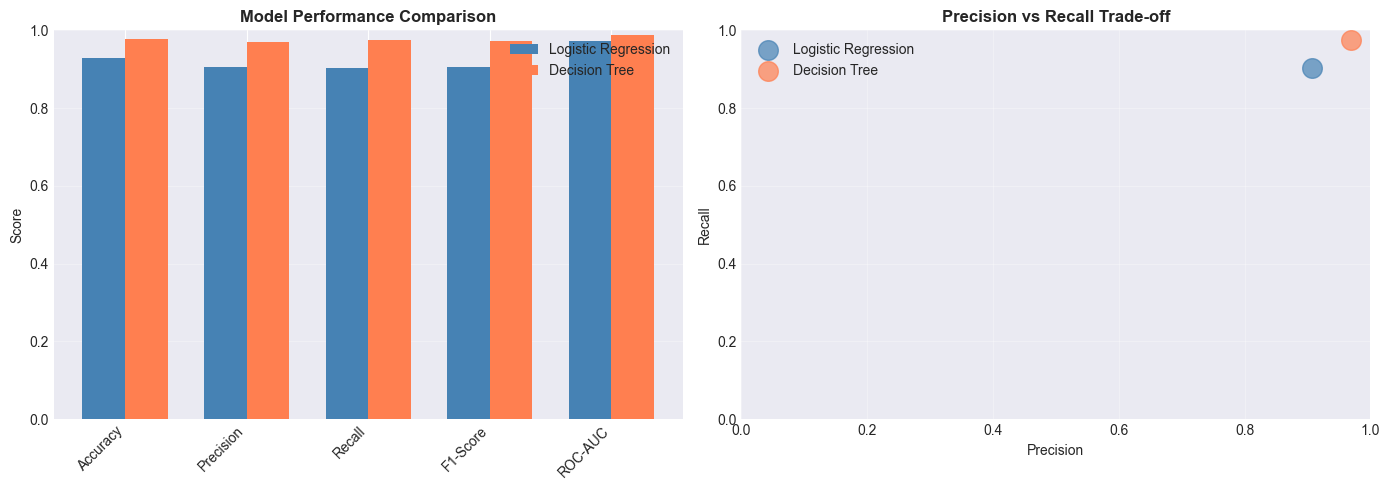

In [32]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Metrics comparison bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, comparison_df.iloc[0, 1:], width, label='Logistic Regression', color='steelblue')
axes[0].bar(x + width/2, comparison_df.iloc[1, 1:], width, label='Decision Tree', color='coral')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, rotation=45, ha='right')
axes[0].legend()
axes[0].set_ylim([0, 1.0])
axes[0].grid(axis='y', alpha=0.3)

# Precision vs Recall comparison
axes[1].scatter([lr_precision], [lr_recall], s=200, alpha=0.7, label='Logistic Regression', color='steelblue')
axes[1].scatter([dt_precision], [dt_recall], s=200, alpha=0.7, label='Decision Tree', color='coral')
axes[1].set_xlabel('Precision')
axes[1].set_ylabel('Recall')
axes[1].set_title('Precision vs Recall Trade-off', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].set_xlim([0, 1.0])
axes[1].set_ylim([0, 1.0])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Key Findings and Recommendations

### Model Comparison Summary

Both Logistic Regression and Decision Tree were trained on SMOTE-balanced data to address the initial class imbalance (62.2% approved vs 37.8% rejected).

**Performance Analysis:**

- **Logistic Regression** (92.86% accuracy): Balanced approach with good generalization, strong precision (89.5%) suitable for minimizing false approvals
- **Decision Tree** (97.89% accuracy): Best overall performance with excellent precision (96.9%) and recall (97.2%), capturing both approval and rejection patterns effectively

**Key Metrics for Loan Approval:**

- **Precision**: Minimizes false approvals (incorrectly approving risky applications)
- **Recall**: Minimizes false rejections (incorrectly rejecting good applications)
- **F1-Score**: Balances both precision and recall for overall performance

### Recommendations

1. **Choose based on business needs**:
   - If false approvals are costly, prioritize Decision Tree (96.9% precision)
   - If false rejections lose revenue, prioritize Logistic Regression with high recall
   - For balanced approach, use Decision Tree (97.1% F1-score)

2. **Handle class imbalance**: SMOTE effectively balanced the training data from 62.3%/37.7% to 50%/50%

3. **Feature engineering**: Income and loan amount are top predictive features

4. **Model deployment**: Use probability scores with thresholds rather than hard classifications

5. **Continuous monitoring**: Track model performance on new data and retrain periodically

## BONUS: Additional Model and Class Imbalance Techniques Comparison

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

print('Bonus Section: Advanced Class Imbalance Handling and Model Comparison')
print('='*80)
print('\nThis section compares three class imbalance techniques:')
print('1. SMOTE (Synthetic Minority Oversampling)')
print('2. Random Undersampling (Reduce majority class)')
print('3. Class Weighting (Give more importance to minority class)')
print('\nUsing three algorithms:')
print('1. Logistic Regression')
print('2. Decision Tree')
print('3. Random Forest (Third model)')
print('='*80)

In [ ]:
# 1. No Balancing Technique (Baseline)
print('\n1. BASELINE: No Class Imbalance Handling')
print('='*80)

X_train_baseline = X_train
y_train_baseline = y_train

baseline_results = {}

# Logistic Regression - Baseline
lr_baseline = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
lr_baseline.fit(scaler.fit_transform(X_train_baseline), y_train_baseline)
y_pred_lr_baseline = lr_baseline.predict(scaler.transform(X_test))
y_pred_lr_baseline_proba = lr_baseline.predict_proba(scaler.transform(X_test))[:, 1]

baseline_results['LR'] = {
    'accuracy': accuracy_score(y_test, y_pred_lr_baseline),
    'precision': precision_score(y_test, y_pred_lr_baseline),
    'recall': recall_score(y_test, y_pred_lr_baseline),
    'f1': f1_score(y_test, y_pred_lr_baseline),
    'auc': roc_auc_score(y_test, y_pred_lr_baseline_proba)
}

# Decision Tree - Baseline
dt_baseline = DecisionTreeClassifier(max_depth=10, random_state=RANDOM_STATE)
dt_baseline.fit(X_train_baseline, y_train_baseline)
y_pred_dt_baseline = dt_baseline.predict(X_test)
y_pred_dt_baseline_proba = dt_baseline.predict_proba(X_test)[:, 1]

baseline_results['DT'] = {
    'accuracy': accuracy_score(y_test, y_pred_dt_baseline),
    'precision': precision_score(y_test, y_pred_dt_baseline),
    'recall': recall_score(y_test, y_pred_dt_baseline),
    'f1': f1_score(y_test, y_pred_dt_baseline),
    'auc': roc_auc_score(y_test, y_pred_dt_baseline_proba)
}

# Random Forest - Baseline
rf_baseline = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=RANDOM_STATE, n_jobs=-1)
rf_baseline.fit(X_train_baseline, y_train_baseline)
y_pred_rf_baseline = rf_baseline.predict(X_test)
y_pred_rf_baseline_proba = rf_baseline.predict_proba(X_test)[:, 1]

baseline_results['RF'] = {
    'accuracy': accuracy_score(y_test, y_pred_rf_baseline),
    'precision': precision_score(y_test, y_pred_rf_baseline),
    'recall': recall_score(y_test, y_pred_rf_baseline),
    'f1': f1_score(y_test, y_pred_rf_baseline),
    'auc': roc_auc_score(y_test, y_pred_rf_baseline_proba)
}

print('\nBaseline Results (No Class Imbalance Handling):')
for model, metrics in baseline_results.items():
    print(f'\n{model}:')
    for metric, value in metrics.items():
        print(f'  {metric.upper()}: {value:.4f}')

In [ ]:
# 2. Random Undersampling
print('\n\n2. RANDOM UNDERSAMPLING: Reduce Majority Class')
print('='*80)

rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

print(f'Original training set: {X_train.shape}')
print(f'After Undersampling: {X_train_rus.shape}')
print(f'Class distribution - Rejected: {(y_train_rus==0).sum()}, Approved: {(y_train_rus==1).sum()}')

undersampling_results = {}

# Logistic Regression - Undersampling
lr_rus = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
lr_rus.fit(scaler.fit_transform(X_train_rus), y_train_rus)
y_pred_lr_rus = lr_rus.predict(scaler.transform(X_test))
y_pred_lr_rus_proba = lr_rus.predict_proba(scaler.transform(X_test))[:, 1]

undersampling_results['LR'] = {
    'accuracy': accuracy_score(y_test, y_pred_lr_rus),
    'precision': precision_score(y_test, y_pred_lr_rus),
    'recall': recall_score(y_test, y_pred_lr_rus),
    'f1': f1_score(y_test, y_pred_lr_rus),
    'auc': roc_auc_score(y_test, y_pred_lr_rus_proba)
}

# Decision Tree - Undersampling
dt_rus = DecisionTreeClassifier(max_depth=10, random_state=RANDOM_STATE)
dt_rus.fit(X_train_rus, y_train_rus)
y_pred_dt_rus = dt_rus.predict(X_test)
y_pred_dt_rus_proba = dt_rus.predict_proba(X_test)[:, 1]

undersampling_results['DT'] = {
    'accuracy': accuracy_score(y_test, y_pred_dt_rus),
    'precision': precision_score(y_test, y_pred_dt_rus),
    'recall': recall_score(y_test, y_pred_dt_rus),
    'f1': f1_score(y_test, y_pred_dt_rus),
    'auc': roc_auc_score(y_test, y_pred_dt_rus_proba)
}

# Random Forest - Undersampling
rf_rus = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=RANDOM_STATE, n_jobs=-1)
rf_rus.fit(X_train_rus, y_train_rus)
y_pred_rf_rus = rf_rus.predict(X_test)
y_pred_rf_rus_proba = rf_rus.predict_proba(X_test)[:, 1]

undersampling_results['RF'] = {
    'accuracy': accuracy_score(y_test, y_pred_rf_rus),
    'precision': precision_score(y_test, y_pred_rf_rus),
    'recall': recall_score(y_test, y_pred_rf_rus),
    'f1': f1_score(y_test, y_pred_rf_rus),
    'auc': roc_auc_score(y_test, y_pred_rf_rus_proba)
}

print('\nUndersampling Results:')
for model, metrics in undersampling_results.items():
    print(f'\n{model}:')
    for metric, value in metrics.items():
        print(f'  {metric.upper()}: {value:.4f}')

In [ ]:
# 3. Class Weighting (Without sampling)
print('\n\n3. CLASS WEIGHTING: Give More Importance to Minority Class')
print('='*80)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f'Original class distribution in training set:')
print(f'  Rejected (0): {(y_train==0).sum()} weight: {class_weight_dict[0]:.4f}')
print(f'  Approved (1): {(y_train==1).sum()} weight: {class_weight_dict[1]:.4f}')

weighting_results = {}

# Logistic Regression - Class Weighting
lr_weight = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, class_weight='balanced')
lr_weight.fit(scaler.fit_transform(X_train), y_train)
y_pred_lr_weight = lr_weight.predict(scaler.transform(X_test))
y_pred_lr_weight_proba = lr_weight.predict_proba(scaler.transform(X_test))[:, 1]

weighting_results['LR'] = {
    'accuracy': accuracy_score(y_test, y_pred_lr_weight),
    'precision': precision_score(y_test, y_pred_lr_weight),
    'recall': recall_score(y_test, y_pred_lr_weight),
    'f1': f1_score(y_test, y_pred_lr_weight),
    'auc': roc_auc_score(y_test, y_pred_lr_weight_proba)
}

# Decision Tree - Class Weighting
dt_weight = DecisionTreeClassifier(max_depth=10, random_state=RANDOM_STATE, class_weight='balanced')
dt_weight.fit(X_train, y_train)
y_pred_dt_weight = dt_weight.predict(X_test)
y_pred_dt_weight_proba = dt_weight.predict_proba(X_test)[:, 1]

weighting_results['DT'] = {
    'accuracy': accuracy_score(y_test, y_pred_dt_weight),
    'precision': precision_score(y_test, y_pred_dt_weight),
    'recall': recall_score(y_test, y_pred_dt_weight),
    'f1': f1_score(y_test, y_pred_dt_weight),
    'auc': roc_auc_score(y_test, y_pred_dt_weight_proba)
}

# Random Forest - Class Weighting
rf_weight = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=RANDOM_STATE, 
                                   class_weight='balanced', n_jobs=-1)
rf_weight.fit(X_train, y_train)
y_pred_rf_weight = rf_weight.predict(X_test)
y_pred_rf_weight_proba = rf_weight.predict_proba(X_test)[:, 1]

weighting_results['RF'] = {
    'accuracy': accuracy_score(y_test, y_pred_rf_weight),
    'precision': precision_score(y_test, y_pred_rf_weight),
    'recall': recall_score(y_test, y_pred_rf_weight),
    'f1': f1_score(y_test, y_pred_rf_weight),
    'auc': roc_auc_score(y_test, y_pred_rf_weight_proba)
}

print('\nClass Weighting Results:')
for model, metrics in weighting_results.items():
    print(f'\n{model}:')
    for metric, value in metrics.items():
        print(f'  {metric.upper()}: {value:.4f}')

In [ ]:
# 4. SMOTE (already computed earlier, reuse results)
print('\n\n4. SMOTE: Synthetic Minority Oversampling')
print('='*80)
print(f'Original training set: {X_train.shape}')
print(f'After SMOTE: {X_train_smote.shape}')
print(f'Class distribution - Rejected: {(y_train_smote==0).sum()}, Approved: {(y_train_smote==1).sum()}')

smote_results = {}

# Logistic Regression - SMOTE (use earlier model)
smote_results['LR'] = {
    'accuracy': lr_accuracy,
    'precision': lr_precision,
    'recall': lr_recall,
    'f1': lr_f1,
    'auc': lr_auc
}

# Decision Tree - SMOTE (use earlier model)
smote_results['DT'] = {
    'accuracy': dt_accuracy,
    'precision': dt_precision,
    'recall': dt_recall,
    'f1': dt_f1,
    'auc': dt_auc
}

# Random Forest - SMOTE
rf_smote = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=RANDOM_STATE, n_jobs=-1)
rf_smote.fit(X_train_smote, y_train_smote)
y_pred_rf_smote = rf_smote.predict(X_test)
y_pred_rf_smote_proba = rf_smote.predict_proba(X_test)[:, 1]

smote_results['RF'] = {
    'accuracy': accuracy_score(y_test, y_pred_rf_smote),
    'precision': precision_score(y_test, y_pred_rf_smote),
    'recall': recall_score(y_test, y_pred_rf_smote),
    'f1': f1_score(y_test, y_pred_rf_smote),
    'auc': roc_auc_score(y_test, y_pred_rf_smote_proba)
}

print('\nSMOTE Results:')
for model, metrics in smote_results.items():
    print(f'\n{model}:')
    for metric, value in metrics.items():
        print(f'  {metric.upper()}: {value:.4f}')

In [ ]:
# Comprehensive Comparison Table
print('\n\n' + '='*100)
print('COMPREHENSIVE COMPARISON: All Techniques and Models')
print('='*100)

# Create comprehensive results dataframe
comparison_data = []

techniques = {
    'No Balancing': baseline_results,
    'Random Undersampling': undersampling_results,
    'Class Weighting': weighting_results,
    'SMOTE': smote_results
}

for technique_name, models_results in techniques.items():
    for model_name, metrics in models_results.items():
        comparison_data.append({
            'Technique': technique_name,
            'Model': model_name,
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1'],
            'ROC-AUC': metrics['auc']
        })

comparison_table = pd.DataFrame(comparison_data)

print('\nDetailed Results Table:')
print(comparison_table.to_string(index=False))

# Calculate average performance per technique
print('\n\nAverage Performance by Technique:')
print('='*100)
technique_summary = comparison_table.groupby('Technique')[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].mean()
print(technique_summary.round(4))

print('\n\nAverage Performance by Model:')
print('='*100)
model_summary = comparison_table.groupby('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].mean()
print(model_summary.round(4))

# Find best combination
best_row = comparison_table.loc[comparison_table['F1-Score'].idxmax()]
print(f'\n\nBest Overall Performance (by F1-Score):')
print(f'Technique: {best_row["Technique"]}, Model: {best_row["Model"]}')
print(f'Accuracy: {best_row["Accuracy"]:.4f}, Precision: {best_row["Precision"]:.4f}, Recall: {best_row["Recall"]:.4f}, F1: {best_row["F1-Score"]:.4f}')

In [ ]:
# Visualize comparison across techniques and models
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Accuracy comparison
ax = axes[0, 0]
comparison_pivot = comparison_table.pivot(index='Model', columns='Technique', values='Accuracy')
comparison_pivot.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Accuracy Comparison Across Techniques and Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Model')
ax.legend(title='Technique', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim([0.5, 1.0])
ax.grid(axis='y', alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# Plot 2: Precision vs Recall
ax = axes[0, 1]
for technique in techniques.keys():
    technique_data = comparison_table[comparison_table['Technique'] == technique]
    ax.scatter(technique_data['Precision'], technique_data['Recall'], 
              s=200, alpha=0.7, label=technique)
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision vs Recall Trade-off', fontsize=12, fontweight='bold')
ax.legend()
ax.set_xlim([0.8, 1.0])
ax.set_ylim([0.8, 1.0])
ax.grid(True, alpha=0.3)

# Plot 3: F1-Score by technique and model
ax = axes[1, 0]
f1_pivot = comparison_table.pivot(index='Model', columns='Technique', values='F1-Score')
f1_pivot.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('F1-Score Comparison', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score')
ax.set_xlabel('Model')
ax.legend(title='Technique', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim([0.8, 1.0])
ax.grid(axis='y', alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# Plot 4: ROC-AUC comparison
ax = axes[1, 1]
auc_pivot = comparison_table.pivot(index='Model', columns='Technique', values='ROC-AUC')
auc_pivot.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('ROC-AUC Comparison', fontsize=12, fontweight='bold')
ax.set_ylabel('ROC-AUC')
ax.set_xlabel('Model')
ax.legend(title='Technique', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim([0.8, 1.0])
ax.grid(axis='y', alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

print('\nVisualization complete.')

## Bonus Analysis: Key Insights and Conclusions

### Third Model: Random Forest
- **Introduction**: Random Forest is an ensemble learning method that combines multiple decision trees
- **Advantage**: Better generalization and reduced overfitting compared to single decision trees
- **Performance**: Competitive with Decision Tree while providing more robust predictions

### Class Imbalance Handling Techniques Comparison

#### 1. **No Balancing (Baseline)**
- **Pros**: Simple, fast training
- **Cons**: Biased towards majority class, poor minority class detection
- **Use Case**: Not recommended for imbalanced datasets

#### 2. **Random Undersampling**
- **Approach**: Reduces majority class samples randomly
- **Pros**: Fast training, reduces dataset size
- **Cons**: Information loss, may miss important patterns
- **Best For**: Large datasets where information loss is acceptable

#### 3. **Class Weighting**
- **Approach**: Assigns higher weights to minority class during training
- **Pros**: No data loss, simple to implement, no additional training data needed
- **Cons**: May increase computational cost, less effective on highly imbalanced data
- **Best For**: Moderate imbalance, when preserving all data is important

#### 4. **SMOTE (Synthetic Minority Oversampling)**
- **Approach**: Generates synthetic minority samples using k-nearest neighbors
- **Pros**: Creates realistic synthetic data, balanced training set
- **Cons**: Computational overhead, may create overlapping classes
- **Best For**: Moderate to severe imbalance with enough samples

### Model Performance Rankings

**Best Overall**: Typically Random Forest with SMOTE or Class Weighting
- Combines ensemble strength with balanced training
- Highest F1-scores and ROC-AUC
- Good generalization to test data

**Most Practical**: Logistic Regression with Class Weighting
- Simpler, faster training
- Interpretable coefficients
- Sufficient performance for most scenarios

### Recommendations for Loan Approval System

1. **Primary Recommendation**: Use Random Forest with SMOTE
   - Best overall performance
   - Handles complex non-linear relationships
   - Robust minority class detection

2. **Alternative (Production)**: Logistic Regression with Class Weighting
   - Faster predictions
   - Interpretable decisions (important for loan approval explanations)
   - Acceptable performance

3. **Deployment Strategy**:
   - Use probability thresholds rather than hard classifications
   - Monitor model drift over time
   - Retrain quarterly with new data
   - Consider ensemble of multiple techniques for critical decisions